# Used Packages

In [1]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

import matplotlib.pyplot as plt
import matplotlib

# Model Creation

In [2]:
PATH = 'data'
# set this parameter if you want to train another model
TRAIN_NEW_MODEL = False
NEW_MODEL_NAME = 'imdb2'

##  Dataset

In [3]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [4]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [5]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
epochs = 1
seed = 42
init_lr = 3e-5

### Splitting Dataset

In [6]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [7]:
if TRAIN_NEW_MODEL:
    # setting the bert encoder and preprocessor
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

    # generating the bert encoder and preprocess layer for the model
    # (save model error can be fixed by deleting temp folder)
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # function for building the classifiert model 
    # text input -> preprocessing -> encode -> droput -> dense 

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    # initialize classifier model
    classifier_model = build_classifier_model()

    # set loss and metric functions
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # create model hyperparameter optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    # early stopping 
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # train the model
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

In [8]:
if TRAIN_NEW_MODEL:
    loss, accuracy = classifier_model.evaluate(test_ds)

In [9]:
if TRAIN_NEW_MODEL:
    saved_model_path = f'./models/{NEW_MODEL_NAME}_bert'
    classifier_model.save(saved_model_path, include_optimizer=False)

# Loading the model and working with it

In [10]:
if not TRAIN_NEW_MODEL:
    saved_model_path = f'models/{os.listdir("models")[1]}'
    model = tf.keras.models.load_model(saved_model_path, compile=False)
else: 
    model = classifier_model

## Get complete test data

In [11]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

## Select random pair

In [86]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]

b"since the plot like Vertigo or Brian DePalma's Obsession, till to the score by Peter Chase that reminds the sounds of Bernard Herrmann, this little pearl seems to be sight from fews. Remarkable playing by Romane Boeringer and Vincent Cassel in a bohemian Paris portrayed from the famous Thierry Arbogast. A little cult! It is a pity that the only version available on DVD are the french one and the English. Directed by a controversial artist as Gilles Mimouni, it could be considered a little homage to the Cinema masterworks. It is a french movie, and as all of them, not for all, we could say a d'essai cinema. Even if not so publicized, it could be remembered for several reason."

In [171]:
#function to classify a text given a model

def classify_text(model, text, parent_ind=None, child_ind=None):
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    if parent_ind or child_ind:
        return (score, pred_label, parent_ind, child_ind)
    else:
        return (score, pred_label)

## Predict random pair

In [172]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nPrediction Strength: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 1 
Prediction Strength: 0.9849092364311218 
Real Label: 1


## Dependecy Parser

In [173]:
depend_parser = spacy.load('en_core_web_sm')

In [174]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [175]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

## Leave-n-out,leave-one-out, strength calculation and linearization

In [176]:
# leave n out 
# go over all tokens, if a token has children, then for every token children pair
# return a text with both removed
def leave_n_out(parsed_text):
    new_texts = []
    for token in parsed_text:
        if token.children:
            for child in token.children:
                new_text = []

                for item in parsed_text:
                    if item.i == token.i or item.i == child.i:
                        pass
                    else:
                        new_text.append(item.text)

                new_texts.append((" ".join(new_text), token.i, child.i))

    return new_texts

In [177]:
def leave_one_out(parsed_text):
    new_texts = []
    for token in parsed_text:
        new_text = []

        for item in parsed_text:
            if item.i == token.i:
                pass
            else: 
                new_text.append(item.text)

        new_texts.append((" ".join(new_text), token.i))

    return new_texts
        

In [178]:
new_texts_lno = leave_n_out(parsed_text)
new_texts_loo = leave_one_out(parsed_text)

### Process leave-n-out texts

In [179]:
# df of all created texts with leave-n-out, with output strength, predicted label, parent index and child index
df_lno = pd.DataFrame([
    classify_text(
        model, text_triple[0], text_triple[1], text_triple[2])
    for text_triple in new_texts_lno],
    columns=['Output Strength',
             'Predicted Label',
             'Parent Index',
             'Child Index'])

df_lno


,Output Strength,Predicted Label,Parent Index,Child Index
0,0.987594,1,0,2
1,0.979294,1,0,10
2,0.983479,1,2,1
3,0.981928,1,2,3
4,0.977596,1,3,4
...,...,...,...,...
125,0.986783,1,131,132
126,0.986783,1,131,135
127,0.986783,1,131,136
128,0.986783,1,132,134


In [180]:
# removes all texts which had the same output strength or better with the word pair removed
# thus not contributing to the prediction
df_lno = df_lno.drop(df_lno.index[df_lno['Output Strength'] >= org_text_pred[0]] )

In [181]:
# adds a new column Strength Difference which captures the difference of the new text prediction and the original
df_lno['Strength Difference'] = org_text_pred[0] - df_lno['Output Strength']


In [182]:
df_lno_copy = df_lno.copy()
df_lno_copy[['Child Index', 'Parent Index']] = df_lno[['Parent Index', 'Child Index']]
df_lno = pd.concat([df_lno, df_lno_copy]).reset_index(drop=True)
df_lno.drop(["Output Strength", "Predicted Label", "Child Index"], inplace=True, axis=1)
df_lno = df_lno.loc[df_lno.groupby(['Parent Index'])["Strength Difference"].idxmax()]
df_lno['Strength Difference'] = MinMaxScaler().fit_transform(df_lno[['Strength Difference']])
df_lno = df_lno.sort_values(by=['Strength Difference'])
df_lno.rename(columns={"Parent Index": "Token Index"}, inplace=True)
df_lno

,Token Index,Strength Difference
112,27,0.000000
92,1,0.000323
98,6,0.003117
9,11,0.007481
2,2,0.008083
...,...,...
143,66,0.488384
52,70,0.488384
132,50,0.658098
131,53,1.000000


### Process leave-one-out texts

In [195]:
df_loo = pd.DataFrame([
    classify_text(
        model, text_tuple[0])
    for text_tuple in new_texts_loo],
    columns=['Output Strength',
             'Predicted Label'])

df_loo.reset_index(inplace=True)
df_loo.rename(columns={'index':'Token Index'}, inplace=True) 
df_loo['Strength Difference'] = org_text_pred[0] - df_loo['Output Strength']
df_loo['Strength Difference'] = MinMaxScaler().fit_transform(df_loo[['Strength Difference']])
df_loo



,Token Index,Output Strength,Predicted Label,Strength Difference
0,0,0.969807,1,0.388034
1,1,0.987323,1,0.147233
2,2,0.990075,1,0.109409
3,3,0.987087,1,0.150482
4,4,0.985475,1,0.172637
...,...,...,...,...
132,132,0.986783,1,0.154655
133,133,0.986783,1,0.154655
134,134,0.986783,1,0.154655
135,135,0.986783,1,0.154655


In [184]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"], gamma=0.75)

In [185]:
def vis_text(df):
    start_x = 20
    start_y = 500
    end = 1200
    whitespace = 8

    figure = plt.figure(figsize=(20, 10))
    rend = figure.canvas.get_renderer()

    for token in parsed_text:
        if df.loc[df["Token Index"] == token.i, 'Strength Difference'].values.size > 0:
            col = cmap(df.loc[df["Token Index"] == token.i, 'Strength Difference'].values[0])
        else: 
            col = "white"
        bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

        # Check if word contains "foot", "feet", "foot." or "feet." or caps locked.
        # Depending what you are trying to achieve.
        txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)
        # Textbox width
        bb = txt.get_window_extent(renderer=rend)

        # Calculate where next word should be written
        start_x = bb.width + start_x + whitespace

        # Next line if end parameter in pixels have been crossed
        if start_x >= end:
            start_x = 20
            start_y -= 20

    plt.axis("off")
    plt.show()

Leave n out:


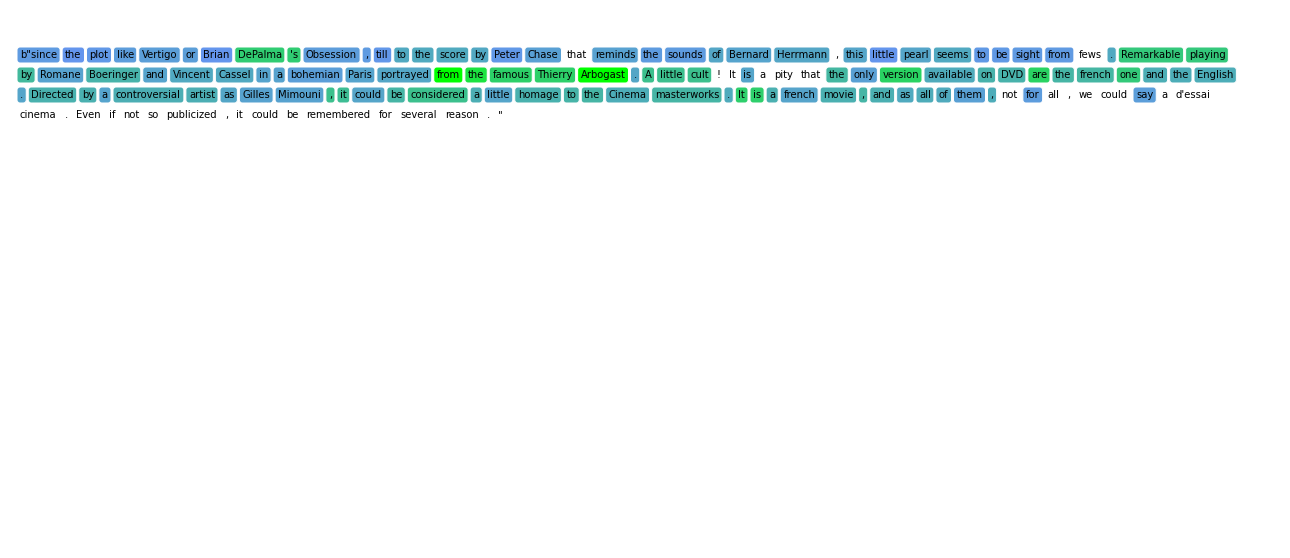

Leave one out:


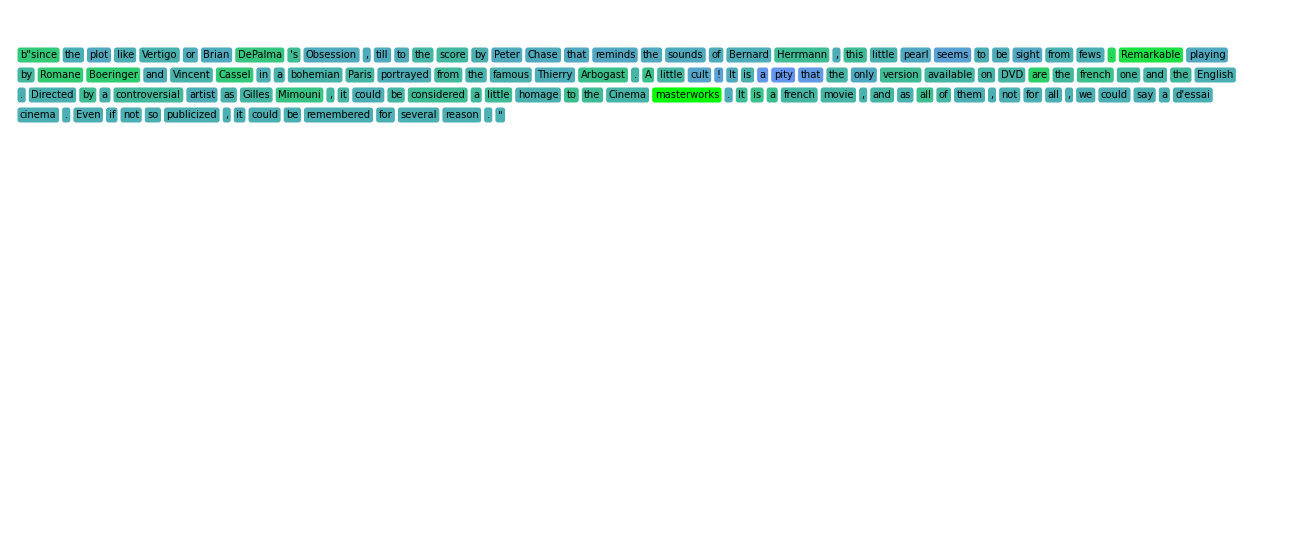

In [200]:
print('Leave n out:')
vis_text(df_lno)
print('Leave one out:')
vis_text(df_loo)